In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight
from Bio.Alphabet import generic_dna, generic_rna, generic_protein

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import pickle

import sys                                                                         
from gffutils.iterators import DataIterator  
from gtfparse import read_gtf

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# gencode 25 metadata 
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')

# gencode 35 metadata 
metadata_pc_g35 = pd.read_csv('tmp_res/metadata_pc_g35.txt', sep='\t')

# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [3]:
PhyloSET = pd.read_csv('tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('tmp_res/SET2.txt', sep='\t')

In [4]:
RiboSET['start_codon_local_coo_start'] = [int(x.split(';')[1].split('-')[0]) for x in RiboSET['Riboseq_Summary'].tolist()]

RiboSET['start_codon'] = [x.split(';')[0] for x in RiboSET['Riboseq_Summary'].tolist()]

In [4]:
RiboSET[['PhyloCSF120score', 'len_codons']]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.327240
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.762814
2,ENST00000338370.7,AURKAIP1,2,401,133.0,chr1:1374757-1374906,-,chr1:1374757-1375155,-2234.0530,111,0;0;0,ATT; 105-402; Rank: 230; cov: 47.87,47.872340,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.063303
3,ENST00000235310.7,MAD2L2,782,929,49.0,chr1:11680602-11680613+chr1:11681039-11681173,-,chr1:11680602-11680613+chr1:11681039-11681173,-2222.6359,111,0;0;0,GTG; 861-930; Rank: 321; cov: 55.56,55.555556,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.094194
4,ENST00000356634.7,KDM1A,2,149,49.0,chr1:23019450-23019596,+,chr1:23019450-23019596,-1883.2964,103,0;0;0,GTG; 63-150; Rank: 37; cov: 87.5,87.500000,2.833333,"basic,appris_principal_3,CCDS",protein_coding,0.981869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,ENST00000330374.6,VMA21,0,105,35.0,chrX:151397204-151397308,+,chrX:151397204-151397308,-1797.1170,100,0;0;0,CTG; 46-106; Rank: 327; cov: 66.67,66.666667,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.052834
391,ENST00000370274.7,NSDHL,2,194,64.0,chrX:152831011-152831117+chrX:152846282-152846324,+,chrX:152830969-152831117+chrX:152846282-152846324,-3415.5044,119,0;0;0,CTG; 120-195; Rank: 334; cov: 60.0,60.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.356544
392,ENST00000447750.6,GDI1,197,335,46.0,chrX:154437117-154437254,+,chrX:154437117-154437254,-1237.3225,90,0;0;0,GTG; 252-336; Rank: 422; cov: 69.57,69.565217,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.282225
393,ENST00000381401.10_PAR_Y,SLC25A6,640,715,25.0,chrY:1392010-1392084,-,chrY:1392010-1392084,-682.8493,50,0;0;0,CTG; 683-716; Rank: 467; cov: 50.0,50.000000,0.000000,"basic,appris_principal_1,CCDS,PAR",protein_coding,1.221763


# The Human Protein Atlas 

In [5]:
localisation_df = pd.read_csv('data/subcellular_location.tsv', sep='\t')

print (localisation_df['Gene name'].nunique())
print (localisation_df[localisation_df['Reliability'].isin(['Supported', 'Approved', 'Enhanced'])]['Gene name'].nunique())
print (localisation_df['Reliability'].unique())

# filter out uncertain location 
sel_loc = localisation_df[localisation_df['Reliability'].isin(['Supported', 'Approved', 'Enhanced'])][['Gene name',
                                                                                                      'Main location',
                                                                                                      'Additional location', 'Extracellular location']]

sel_loc.columns = ['gene', 'Main location', 'Additional location', 'Extracellular location']

sel_loc[0:2]

12804
12086
['Approved' 'Uncertain' 'Supported' 'Enhanced']


,gene,Main location,Additional location,Extracellular location
0,TSPAN6,Cell Junctions;Cytosol,Nucleoli fibrillar center,NaN
2,C1orf112,Mitochondria,NaN,NaN


# RiboSET & HPA localisation 

In [6]:
# !!!!!!!! exclude AUG extensions !!!!!! 
# 392 genes with non-AUG and 3 with AUG 

RiboSET_loc = RiboSET[~RiboSET['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])][['gene']].merge(sel_loc, on='gene', how='inner')
print (RiboSET_loc.gene.nunique())

RiboSET_loc['location'] = RiboSET_loc['Main location']+';'+RiboSET_loc['Additional location'].astype(str)+';'+RiboSET_loc['Extracellular location'].astype(str)
RiboSET_loc['location'] = RiboSET_loc['location'].str.replace('nan;', '').str.replace('nan', '').str.rstrip(';')

RiboSET_loc.to_csv('tmp_res/RiboSET_location_HPA.txt', sep='\t', index=False)

RiboSET_loc[0:2]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


317


,gene,Main location,Additional location,Extracellular location,location
0,AURKAIP1,Mitochondria;Nucleoplasm,NaN,NaN,Mitochondria;Nucleoplasm
1,MAD2L2,Cytosol,Nucleoli,NaN,Cytosol;Nucleoli


In [7]:
nucleoplasm_count = 0
cytosol_count = 0
Mitochondria_count = 0
membrane_count = 0

two_more_loc = 0

all_locations = set()

for i,x in enumerate(RiboSET_loc['location'].tolist()):
    
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x.find('Nucleoplasm') != -1:
        nucleoplasm_count += 1
    if x.find('Cytosol') != -1:
        cytosol_count += 1
    if x.find('Mitochondria') != -1:
        Mitochondria_count += 1
    if x.find('Plasma membrane') != -1:
        membrane_count += 1
        
    if len(x.split(';')) >= 2:
        two_more_loc += 1
        
        # search for Mitochondria + smth 
        #if 'Mitochondria' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
        
        
        # search for ER, Golgi apparatus, vesicles + smth 
        #if 'Vesicles' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
            
        #if 'Golgi apparatus' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
        
        #if 'Endoplasmic reticulum' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
            
        #if 'Plasma membrane' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
    
nucleoplasm_count, cytosol_count, Mitochondria_count, membrane_count, two_more_loc

(149, 126, 23, 39, 167)

In [8]:
# RiboSET_loc.groupby(by='location').count().sort_values(by='gene', ascending=False)[0:12]

## Plot 

In [15]:
RiboSET_loc.groupby(by=['location']).count().sort_values(by='gene', ascending=False)[0:10]

,gene,Main location,Additional location,Extracellular location
location,,,,
Nucleoplasm,45,45,0,0
Cytosol,39,39,0,0
Cytosol;Nucleoplasm,17,17,7,0
Mitochondria,14,14,0,0
Vesicles,12,12,0,0
Endoplasmic reticulum,11,11,0,0
Cytosol;Plasma membrane,9,9,0,0
Golgi apparatus,8,8,0,0
Nucleoplasm;Cytosol,7,7,7,0


In [23]:
diff_2_loc = ['Mitochondria;Nucleoplasm', 
        'Cytosol;Nucleoli',
       'Nucleoplasm;Cytosol', 
        'Cytosol;Nucleoplasm',
        #'Centriolar satellite', 
        'Cytosol;Vesicles', 
        #'Cell Junctions',
        #'Nuclear speckles', 
       'Nucleoplasm;Midbody ring',
       'Cytosol;Nucleoplasm;Plasma membrane',
       'Vesicles;Predicted to be secreted', 
       'Golgi apparatus;Nucleoli',
       #'Nucleoplasm;Nuclear bodies', 
       'Nucleoli;Cytosol',
       'Cytosol;Plasma membrane',
       'Endoplasmic reticulum;Plasma membrane;Predicted to be secreted',
       'Nucleoplasm;Centrosome', 
       'Nucleoplasm;Golgi apparatus',
       #'Nuclear bodies;Nucleoplasm;Centrosome',
       'Cytosol;Endoplasmic reticulum',
       #'Nucleoli fibrillar center;Nucleoplasm',
       'Plasma membrane;Vesicles', 
       'Endoplasmic reticulum;Nucleoplasm',
       'Cytosol;Nucleoli fibrillar center',
       'Endoplasmic reticulum;Predicted to be secreted',
       #'Nuclear bodies;Nucleoplasm', 
       'Centrosome;Nucleoplasm;Cytosol',
       'Nuclear speckles;Cytoplasmic bodies',
       'Cytosol;Vesicles;Predicted to be secreted',
       'Golgi apparatus;Cytosol;Nucleoplasm',
       #'Nucleoli;Nucleoli rim;Nucleoplasm',
       'Cytosol;Nucleoli;Plasma membrane', 
       #'Actin filaments',
       'Cytosol;Focal adhesion sites', 
       'Vesicles;Golgi apparatus',
       'Cell Junctions;Cytosol;Nucleoplasm;Predicted to be secreted',
       'Cytosol;Golgi apparatus;Nucleoli;Nucleoplasm',
       'Nucleoplasm;Vesicles',
       'Cytosol;Plasma membrane;Centrosome;Vesicles',
       #'Nuclear speckles;Nucleoli fibrillar center',
       'Cytosol;Nuclear bodies',
       'Nucleoplasm;Plasma membrane',
       #'Nucleoli rim;Nucleoplasm', 
       'Nuclear speckles;Cytosol',
       'Nucleoplasm;Cytosol;Vesicles',
       'Plasma membrane;Cytosol;Endoplasmic reticulum;Nucleoplasm',
       'Golgi apparatus;Vesicles;Predicted to be secreted',
       'Golgi apparatus;Vesicles', 
       #'Nuclear membrane;Nucleoplasm',
       #'Centrosome;Nucleoli;Nucleoplasm',
       'Vesicles;Nucleoplasm',
       'Cell Junctions;Cytosol', 
       'Cytosol;Predicted to be secreted',
       'Nucleoli;Mitochondria;Nucleoplasm',
       'Nucleoplasm;Cytosol;Intermediate filaments',
       'Golgi apparatus;Nucleoplasm;Cell Junctions',
       'Plasma membrane;Nucleoplasm;Predicted to be secreted',
       #'Microtubules', 
       'Nucleoplasm;Cytosol;Nuclear bodies',
       'Nucleoplasm;Cytosol;Plasma membrane',
       'Nucleoplasm;Cell Junctions;Cytosol', 
       'Lipid droplets;Nucleoplasm',
       #'Peroxisomes',
       'Golgi apparatus;Plasma membrane;Actin filaments',
       'Golgi apparatus;Cytosol;Vesicles',
       'Nucleoplasm;Centrosome;Cytosol',  
       'Cytosol;Nuclear membrane',
       'Nucleoplasm;Golgi apparatus;Vesicles', 
       #'Nuclear bodies',
       #'Nucleoplasm;Nucleoli fibrillar center',
       'Focal adhesion sites;Plasma membrane',
       #'Nucleoli;Nucleoplasm;Nuclear membrane',
       'Cytokinetic bridge;Microtubules;Midbody;Plasma membrane;Nucleoplasm',
       'Nucleoplasm;Cytokinetic bridge;Cytosol', 
       #'Nucleoli',
       'Mitochondria;Nucleoli;Nucleoplasm;Predicted to be secreted',
       'Vesicles;Nucleoli;Nucleoplasm',
       'Endoplasmic reticulum;Golgi apparatus',
       #'Nuclear bodies;Centriolar satellite',
       'Nucleoplasm;Centrosome;Microtubules', 
       #'Nucleoli;Nucleoplasm',
       'Cytosol;Nucleoli rim;Nucleoplasm',
       'Cytosol;Vesicles;Centriolar satellite;Mitotic spindle',
       'Plasma membrane;Mitochondria',
       'Nucleoplasm;Plasma membrane;Midbody ring',
       'Cytosol;Nuclear bodies;Nucleoplasm',
       'Cytosol;Plasma membrane;Focal adhesion sites',
       'Cytosol;Nucleoplasm;Cytokinetic bridge;Mitotic spindle',
       'Endoplasmic reticulum;Nucleoli', 
       'Lysosomes;Vesicles',
       'Midbody;Nucleoplasm', 
       'Nuclear membrane;Nucleoplasm;Cytosol',
       'Nuclear speckles;Nucleoplasm;Cytosol', 
       'Nucleoplasm;Midbody',
       'Golgi apparatus;Cytosol;Predicted to be secreted',
       'Mitochondria;Nucleoli', 
       'Cytosol;Plasma membrane;Nucleoplasm',
       'Cytosol;Golgi apparatus;Plasma membrane',
       'Cytosol;Endoplasmic reticulum;Nucleoli',
       'Nucleoplasm;Cytosol;Nuclear bodies;Nucleoli',
       'Nucleoplasm;Cell Junctions', 
       'Cytosol;Cytokinetic bridge',
       'Cytosol;Nuclear membrane;Nucleoplasm',
       'Endoplasmic reticulum;Lipid droplets']

In [29]:
#RiboSET_loc[~RiboSET_loc['location'].isin(['Nucleoplasm', 'Cytosol', 
#               'Mitochondria', 'Vesicles', 'Endoplasmic reticulum', 'Golgi apparatus',
#          'Plasma membrane'])].location.unique()


RiboSET_loc[RiboSET_loc['location'].isin(diff_2_loc)].gene.nunique(), #182-146

182-167

15

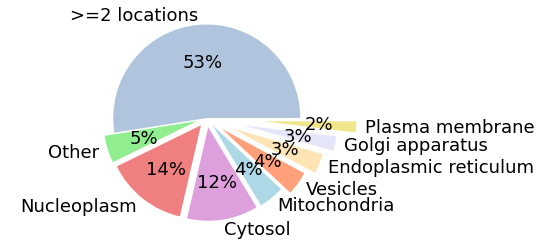

In [42]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))


group_names = ['>=2 locations', 'Other', 'Nucleoplasm', 'Cytosol', 
               'Mitochondria', 'Vesicles', 'Endoplasmic reticulum', 'Golgi apparatus',
          'Plasma membrane'] 

counts = pd.Series([167, 15, 45, 39, 14, 13, 11, 8, 6], 
                   index=['>=2 locations', 'Other', 'Nucleoplasm', 'Cytosol', 'Mitochondria', 
                          'Vesicles', 'Endoplasmic reticulum', 'Golgi apparatus',
          'Plasma membrane'])

explode = (0, 0.11, 0.1, 0.1, 0.1, 0.2, 0.3, 0.4, 0.6)
colors = ['lightsteelblue', 'lightgreen', 'lightcoral', 'plum', 'lightblue', 'lightsalmon', 'moccasin', 'lavender', 
          'khaki' ]

counts.plot(kind='pie', fontsize=18, colors=colors, 
            explode=explode, labels=group_names, autopct='%1.0f%%', ax=ax)
plt.axis('equal')
plt.ylabel('')

plt.show()  


# PhyloSET & HPA localisation 

In [43]:
PhyloSET_loc = PhyloSET[['gene']].merge(sel_loc, on='gene', how='inner')
print (PhyloSET_loc.gene.nunique())

PhyloSET_loc['location'] = PhyloSET_loc['Main location']+';'+PhyloSET_loc['Additional location'].astype(str)+';'+PhyloSET_loc['Extracellular location'].astype(str)
PhyloSET_loc['location'] = PhyloSET_loc['location'].str.replace('nan;', '').str.replace('nan', '').str.rstrip(';')

PhyloSET_loc.to_csv('tmp_res/Phylo_location_HPA.txt', sep='\t', index=False)

PhyloSET_loc[0:2]

40


,gene,Main location,Additional location,Extracellular location,location
0,HES3,Nucleoplasm,NaN,NaN,Nucleoplasm
1,IFFO2,Nucleoplasm;Plasma membrane,NaN,NaN,Nucleoplasm;Plasma membrane


In [44]:
nucleoplasm_count = []
cytosol_count = []
Mitochondria_count = []
membrane_count = []

two_more_loc = []

all_locations = set()

for i,x in enumerate(PhyloSET_loc['location'].tolist()):
    
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x.find('Nucleoplasm') != -1:
        nucleoplasm_count.append(PhyloSET_loc.iloc[i].gene)
    if x.find('Cytosol') != -1:
        cytosol_count.append(PhyloSET_loc.iloc[i].gene)
    if x.find('Mitochondria') != -1:
        Mitochondria_count.append(PhyloSET_loc.iloc[i].gene)
    if x.find('Plasma membrane') != -1:
        membrane_count.append(PhyloSET_loc.iloc[i].gene)
        
    if len(x.split(';')) >= 2:
        two_more_loc.append(PhyloSET_loc.iloc[i].gene)
        
        # search for Mitochondria + smth 
        #if 'Mitochondria' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
        
        
        # search for ER, Golgi apparatus, vesicles + smth 
        #if 'Vesicles' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
            
        #if 'Golgi apparatus' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
        
        #if 'Endoplasmic reticulum' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
            
        #if 'Plasma membrane' in x.split(';'):
            #print (RiboSET_loc.iloc[i].gene, RiboSET_loc.iloc[i]['Main location'])
    
len(set(nucleoplasm_count)), len(set(cytosol_count)), len(set(Mitochondria_count)), len(set(membrane_count)), len(set(two_more_loc))

(26, 14, 2, 8, 20)

### plot 

In [45]:
PhyloSET_loc = PhyloSET_loc.drop_duplicates()

# PhyloSET_loc.groupby(by='location').count().sort_values(by='gene', ascending=False)[0:12]

PhyloSET_loc.groupby(by='location').count().gene.sum()-11-5-2

22

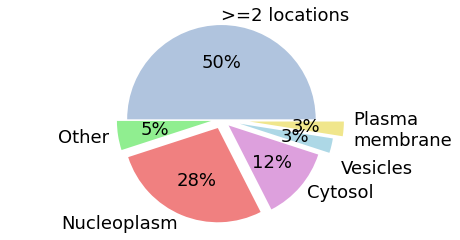

In [47]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))


group_names = ['>=2 locations', 'Other', 'Nucleoplasm', 'Cytosol',  '\n\nVesicles', 'Plasma\nmembrane'] 

counts = pd.Series([20, 2, 11, 5, 1, 1], 
                   index=['>=2 locations', 'Other', 'Nucleoplasm', 'Cytosol',  'Vesicles', 'Plasma membrane'])

explode = (0, 0.11, 0.1, 0.1, 0.2, 0.3)
colors = ['lightsteelblue', 'lightgreen', 'lightcoral', 'plum', 'lightblue', 'khaki']

counts.plot(kind='pie', fontsize=18, colors=colors, 
            explode=explode, labels=group_names, autopct='%1.0f%%', ax=ax)
plt.axis('equal')
plt.ylabel('')

plt.show()  

# SignalP data 

### RiboSET: get .fasta file and df with ext lenght and sequence 

In [481]:
riboset_fasta = open('data/tmhmm_and_phobius_data/riboset.fasta', 'w')

li = []

for row in RiboSET[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'start_codon_local_coo_start']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    N_term_start_pred = row[-1] - 1
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]
    nte_seq_nt2 = tr_seq[N_term_start_pred:cds_stop]
    
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    nte_seq_aa2 = 'M'+str(Seq(nte_seq_nt2).translate())[1:]
    
    # position of CDS in NTE_aa: 
    # 5'    N_term_start_pred    cds_start_pos
    # 
    cds_start_aa_in_ext2 = (cds_start - N_term_start_pred) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, nte_seq_aa2, cds_start_aa_in_ext2, 
              cds_start_aa_in_ext2])
    
    riboset_fasta.write('>'+tr_id+'_'+gene+'\n')
    riboset_fasta.write(nte_seq_aa2[:-1]+'\n')
  
riboset_fasta.close()
        
NTE_aa_df_ribo = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 'nte_seq_aa2',
                                       'cds_start_aa_in_ext2', 'ext_len'])


In [482]:
NTE_aa_df_ribo[0:2]

,tr_id,gene,nte_seq_aa1,nte_seq_aa2,cds_start_aa_in_ext2,ext_len
0,ENST00000379389.4,ISG15,AGSAARPLTCVPQAYNRAGAACRSRRLRGSELIFASTGACAVAHSP...,MFASTGACAVAHSPQPTAMGWDLTVKMLAGNEFQVSLSSSMSVSEL...,18,18
1,ENST00000349431.10,UBE2J2,AGSAPRAAILEAEAAAAALRRVRWAQSRGGAAVSGAGPAFPHPAPA...,MASLSAAAAHAQRQGEMSSTSSKRAPTTATQRLKQDYLRIKKDPVP...,16,16


### parse SignalP output

In [484]:
signalP_df_r = pd.read_csv('data/SignalP_RiboSET_output_protein_type.txt', sep='\t', comment='#', header=None)
signalP_df_r.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df_r['tr_id'] = [x.split('_')[0] for x in signalP_df_r['id'].tolist()]
signalP_df_r['gene'] = [x.split('_')[-1] for x in signalP_df_r['id'].tolist()]

# exclude AUGs 
signalP_df_r = signalP_df_r[~signalP_df_r['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

print ('# of genes with pred signalP from RiboSET')
signalP_df_r[(signalP_df_r['class'] != 'OTHER') & (signalP_df_r['SP_seq'] != 'CS pos: ?. Probable protein fragment')].gene.nunique()

# of genes with pred signalP from RiboSET


28

### SignalP + HPA 

In [485]:
signalP_and_loc_riboset = RiboSET_loc[['gene', 'Main location']].drop_duplicates().merge(signalP_df_r, on='gene', how='inner')

print ('# of genes with pred signalP and with localisation from RiboSET')
signalP_and_loc_riboset[(signalP_and_loc_riboset['class'] != 'OTHER') & (signalP_and_loc_riboset['SP_seq'] != 'CS pos: ?. Probable protein fragment')].shape[0]

# of genes with pred signalP and with localisation from RiboSET


22

In [486]:
count = 0

for row in signalP_and_loc_riboset[(signalP_and_loc_riboset['class'] != 'OTHER') & (signalP_and_loc_riboset['SP_seq'] != 'CS pos: ?. Probable protein fragment')].to_numpy():
    loc = row[1]
    tr_id = row[0]
    
    if (loc.find('Golgi apparatus') != -1) | (loc.find('Plasma membrane') != -1) | (loc.find('Endoplasmic reticulum') != -1) | (loc.find('Vesicles') != -1):
        #print (tr_id, loc)
        count += 1

print ('# of genes with GA, PM, ER, vesicles location and signalP pred from RiboSET:', count)

# of genes with GA, PM, ER, vesicles location and signalP pred from RiboSET: 16


### Check whether position of SP is in extension 

In [487]:
tmp = signalP_and_loc_riboset[(signalP_and_loc_riboset['class'] != 'OTHER') & 
                              (signalP_and_loc_riboset['SP_seq'] != 'CS pos: ?. Probable protein fragment')]
tmp['SP_end_pos'] = [int(x.split('CS pos: ')[1].split('-')[0]) for x in tmp['SP_seq'].tolist()]

tmp = tmp.merge(NTE_aa_df_ribo, on=['tr_id', 'gene'], how='inner')

print (tmp.shape[0]) #21

tmp['SP_start_pos'] = tmp['SP_end_pos'] - 16


22


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### CS before CDS start

In [474]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_end_pos']].gene.tolist()

['RAE1']

#### genes with CS-16 position before CDS 

In [475]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['gene'].tolist()

['STMN1', 'DPH5', 'ZNF622', 'SUPT4H1', 'RAE1']

# All RiboSET genes vs SignalP (even if no HPA data)

In [488]:
tmp2 = signalP_df_r[(signalP_df_r['class'] != 'OTHER') & (signalP_df_r['SP_seq'] != 'CS pos: ?. Probable protein fragment')]

tmp2['SP_end_pos'] = [int(x.split('CS pos: ')[1].split('-')[0]) for x in tmp2['SP_seq'].tolist()]

tmp3 = tmp2.merge(NTE_aa_df_ribo, on=['tr_id', 'gene'], how='inner')

tmp3['SP_start_pos'] = tmp3['SP_end_pos'] - 16

print (tmp3.shape[0])

29


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [489]:
tmp3[tmp3['cds_start_aa_in_ext2'] >= tmp3['SP_end_pos']].merge(RiboSET_loc, on=['gene'], how='left').gene.tolist()

['RAE1']

In [490]:
# ADAM15:  has signal P pred but unknown localistion in Human Protein Atlas 

tmp3[tmp3['cds_start_aa_in_ext2'] >= tmp3['SP_start_pos']].merge(RiboSET_loc, on=['gene'], how='left').gene.tolist()

['STMN1', 'DPH5', 'ADAM15', 'ZNF622', 'SUPT4H1', 'RAE1']

# PhyloSET genes: signalP on theoretical extension 

In [491]:
li = []

f = open('data/tmhmm_and_phobius_data/phyloset.fasta', 'w')

for row in PhyloSET[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]
    
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    
    # position of CDS in NTE_aa: 
    # 5'    N_term_start_pred    cds_start_pos
    # 
    cds_start_aa_in_ext2 = (cds_start - N_term_start) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, cds_start_aa_in_ext2])
    
    f.write('>'+tr_id+'_'+gene+'\n')
    f.write(nte_seq_aa1[:-1]+'\n')
    
NTE_aa_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 
                                       'cds_start_aa_in_ext2'])

f.close()

### signalP output 

In [492]:
signalP_df = pd.read_csv('data/SignalP_PCSF.txt', sep='\t', comment='#', header=None)
signalP_df.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df['tr_id'] = [x.split('_')[0] for x in signalP_df['id'].tolist()]
signalP_df['gene'] = [x.split('_')[-1] for x in signalP_df['id'].tolist()]

In [493]:
print ('# of genes with pred signalP from PhyloSET')
signalP_df[(signalP_df['class'] != 'OTHER') & 
           (signalP_df['SP_seq'] != 'CS pos: ?. Probable protein fragment')].shape[0]

# of genes with pred signalP from PhyloSET


0

# TargetP: mitochondrial presequence, RIBOSET

In [42]:
targetP_riboset = pd.read_csv('data/TargetP_RiboSET.txt', sep='\t', comment='#', header=None)
targetP_riboset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_riboset['tr_id'] = [x.split('_')[0] for x in targetP_riboset['ids'].tolist()]
targetP_riboset['gene'] = [x.split('_')[-1] for x in targetP_riboset['ids'].tolist()]

targetP_riboset = targetP_riboset[~targetP_riboset['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

print ('genes from RiboSET with mito signal: ')

print (targetP_riboset[(targetP_riboset['seq_m'].notna()) & (targetP_riboset['class'] == 'mTP')].gene.nunique())

genes from RiboSET with mito signal: 
16


In [44]:
print ('how many of them have mitochondiral location? only 2 actually hmm')

tmp = RiboSET_loc.merge(targetP_riboset[(targetP_riboset['seq_m'].notna()) & 
                                  (targetP_riboset['class'] == 'mTP')], on='gene', how='inner')

tmp[tmp['Main location'].str.contains('Mitochondria')].gene.tolist()

how many of them have mitochondiral location? only 2 actually hmm


['TRMT10C', 'MRPS7']

### check if CS < cds 

In [47]:
tmp = targetP_riboset[(targetP_riboset['seq_m'].notna()) & 
                      (targetP_riboset['class'] == 'mTP')].merge(NTE_aa_df_ribo, on=['gene', 'tr_id'], how='inner')

print (tmp.shape[0])

tmp['CS_pos'] = [int(x.split('CS pos:')[1].split('-')[0]) for x in tmp['seq_m'].tolist()]
tmp['m_start'] = tmp['CS_pos']-20

16


In [48]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['CS_pos']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(RiboSET_loc, on='gene', how='left').gene.tolist()

['GNAI1', 'RFK', 'CDK2', 'HSPH1', 'GNA13']

### check if CS-n < cds 

In [49]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(RiboSET_loc, on='gene', how='left').gene.tolist()

['GCLM',
 'ACTL6A',
 'NSUN2',
 'COX7C',
 'GNAI1',
 'RFK',
 'TNKS2',
 'CDK2',
 'HSPH1',
 'GNA13',
 'ADRM1']

# PhyloSET TargetP

In [50]:
targetP_phyloset = pd.read_csv('data/TargetP_PhyloSET.txt', sep='\t', comment='#', header=None)
targetP_phyloset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_phyloset['tr_id'] = [x.split('_')[0] for x in targetP_phyloset['ids'].tolist()]
targetP_phyloset['gene'] = [x.split('_')[-1] for x in targetP_phyloset['ids'].tolist()]

print ('genes from RiboSET with mito signal: ')

print (targetP_phyloset[(targetP_phyloset['seq_m'].notna()) & (targetP_phyloset['class'] == 'mTP')].gene.nunique())

genes from RiboSET with mito signal: 
0


# TMHMM: RiboSET

cat ../../riboset.fasta | ./decodeanhmm.Linux_x86_64 -f ../lib/TMHMM2.0.options -modelfile ../lib/TMHMM2.0.model > riboset.result

In [306]:
my_file = open("/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_and_phobius_data/tmhmm-2.0c/bin/riboset.result", "r")
content = my_file.read()

li = content.split('>')

parse = []

for tr in [x.split('\n%') for x in li[1:]]:
    tr_id = tr[0].split('_')[0]
    gene = tr[0].split('_')[-1]
    
    #print (tr_id)
    length = int(tr[1].split('len ')[1])
    
    #pred = tr[7].split('\n')[0].split('pred NM(0): ')[1]
    
    prediction_seq = ''
    real_seq = ''

    for el in list(filter(None, tr[-1].split('\n')))[1:]:
        if el.startswith('?0'):
            prediction_seq += el.split('?0 ')[1]
        else:
            real_seq += el.strip(' ')
            
    real_len = len(real_seq)
    pred_len = len(prediction_seq)
    
    any_m = False
    pos_of_1st_m = False
    
    if ('M' in list(prediction_seq)):
        any_m = True 
        pos_of_1st_m = prediction_seq.find('M')
    if ('m' in list(prediction_seq)):
        any_m = True 
        pos_of_1st_m = prediction_seq.find('m')
            
            
    parse.append([tr_id, gene, length, real_seq, prediction_seq, 
                  real_len, pred_len, any_m, pos_of_1st_m])
    
    
parse_df_r = pd.DataFrame(parse, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])


parse_df_r[(parse_df_r['any_m'] == True) & 
         (~parse_df_r['gene'].isin(['PTPRJ', 'STIM2', 'AP3S1']))].to_csv('tmp_res/TMHMM_RiboSET_83genes_with_TM_regions.txt', sep='\t', index=False)

print ('# gene with at least one TM helix located anywhere: ', parse_df_r[(parse_df_r['any_m'] == True) & 
                                                                        (~parse_df_r['gene'].isin(['PTPRJ', 'STIM2', 'AP3S1']))].gene.nunique())

# gene with at least one TM helix located anywhere:  83


### select genes where TM start is predicted before CDS 

In [314]:
TMHMM_riboset_preds = NTE_aa_df_ribo[['tr_id', 'gene', 'ext_len']].merge(parse_df_r[parse_df_r['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['ext_len']].gene.unique()

array(['PDIA6', 'TRMT10C', 'SOX2', 'LY6K', 'CD59', 'TIMP3', 'KDELR3',
       'CD99'], dtype=object)

### any genes with SP??

In [315]:
signalP_riboset = ['STMN1', 'DPH5', 'ADAM15', 'ZNF622', 'SUPT4H1', 'RAE1']

# not really 

### plot them

In [316]:
import itertools

coordinates = {}

for row in TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['ext_len']][['gene', 'prediction_seq']].to_numpy():
    gene = row[0]
    seq = row[1]
    
    coordinates[gene] = []
    
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        
        coordinates[gene].append(block) 

In [317]:
coordinates

{'PDIA6': [['i', 0, 8], ['M', 8, 31], ['O', 31, 450]],
 'TRMT10C': [['i', 0, 6], ['M', 6, 29], ['O', 29, 421]],
 'SOX2': [['i', 0, 16], ['M', 16, 36], ['O', 36, 402]],
 'LY6K': [['o', 0, 50],
  ['M', 50, 73],
  ['i', 73, 201],
  ['M', 201, 221],
  ['o', 221, 222]],
 'CD59': [['o', 0, 14], ['M', 14, 37], ['i', 37, 144]],
 'TIMP3': [['i', 0, 6], ['M', 6, 29], ['O', 29, 226]],
 'KDELR3': [['o', 0, 33],
  ['M', 33, 56],
  ['i', 56, 90],
  ['M', 90, 113],
  ['o', 113, 127],
  ['M', 127, 143],
  ['i', 143, 149],
  ['M', 149, 172],
  ['o', 172, 181],
  ['M', 181, 201],
  ['i', 201, 213],
  ['M', 213, 235],
  ['o', 235, 249]],
 'CD99': [['i', 0, 12],
  ['M', 12, 35],
  ['o', 35, 138],
  ['M', 138, 161],
  ['i', 161, 198]]}

In [318]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

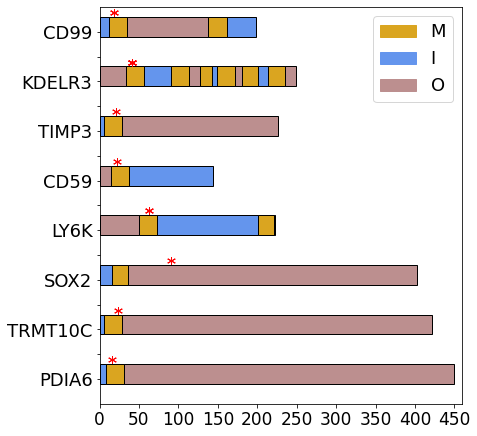

In [319]:
fig, ax = plt.subplots(1, figsize=(6.5, 7.3))

ax.set_ylim(0, 8)
ax.set_yticks(np.arange(0.5, 8, 0.5))

l = [[x, ''] * 1 for x in list(coordinates.keys())]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 460)
ax.set_xticks(np.arange(0, 460, 50))
ax.set_xticklabels(np.arange(0, 460, 50), fontsize=17)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0]
    coo = blocks[1]
    
    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'M') | (feat_type == 'm'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif (feat_type == 'o') | (feat_type == 'O'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'rosybrown'))
        elif feat_type == 'i':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            continue
         
        cds_pos = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len
        plt.text(x=cds_pos, y=y1+0.30, s='*', color='red', size=18)
        

# legend 

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='M')
I = mpatches.Patch(color='cornflowerblue', label='I')
O = mpatches.Patch(color='rosybrown', label='O')

plt.legend(handles=[M, I, O])

# TMHMM: PhyloSET

In [320]:
my_file = open("/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_data/tmhmm-2.0c/bin/phyloset.result", "r")
content = my_file.read()

li = content.split('>')

parse = []

for tr in [x.split('\n%') for x in li[1:]]:
    tr_id = tr[0].split('_')[0]
    gene = tr[0].split('_')[-1]
    
    #print (tr_id)
    length = int(tr[1].split('len ')[1])
    
    #pred = tr[7].split('\n')[0].split('pred NM(0): ')[1]
    
    prediction_seq = ''
    real_seq = ''

    for el in list(filter(None, tr[-1].split('\n')))[1:]:
        if el.startswith('?0'):
            prediction_seq += el.split('?0 ')[1]
        else:
            real_seq += el.strip(' ')
            
    real_len = len(real_seq)
    pred_len = len(prediction_seq)
    
    any_m = False
    pos_of_1st_m = False
    
    if ('M' in list(prediction_seq)):
        any_m = True 
        pos_of_1st_m = prediction_seq.find('M')
    if ('m' in list(prediction_seq)):
        any_m = True 
        pos_of_1st_m = prediction_seq.find('m')
            
            
    parse.append([tr_id, gene, length, real_seq, prediction_seq, 
                  real_len, pred_len, any_m, pos_of_1st_m])
    
    
parse_df = pd.DataFrame(parse, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])



print (parse_df[(parse_df['any_m'] == True)].gene.nunique())

FileNotFoundError: [Errno 2] No such file or directory: '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_data/tmhmm-2.0c/bin/phyloset.result'

In [144]:
parse_df[(parse_df['any_m'] == True)].to_csv('tmp_res/TMHMM_PhyloSET_Xgenes_with_TM_regions.txt', sep='\t', index=False)



In [143]:
print ('# gene with at least one TM helix located anywhere: ', parse_df[(parse_df['any_m'] == True)].gene.nunique())

# gene with at least one TM helix located anywhere:  12


In [146]:
TMHMM_phyloset_preds = NTE_aa_df[['tr_id', 'gene', 'cds_start_aa_in_ext2']].merge(parse_df[parse_df['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].gene.unique()

array(['C1QL2', 'C1QL3', 'SULT1A1', 'AC007906.1'], dtype=object)

In [173]:
# select only 4 transcripts 
tmp = TMHMM_phyloset_preds[(TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']) & 
                    TMHMM_phyloset_preds['tr_id_x'].isin(['ENST00000272520.3', 'ENST00000619991.1', 
                                                          'ENST00000350842.8', 'ENST00000624244.1'])][['tr_id_x', 'gene', 'prediction_seq', 
                                                                                                       'pos_of_1st_m', 'cds_start_aa_in_ext2']]

tmp

,tr_id_x,gene,prediction_seq,pos_of_1st_m,cds_start_aa_in_ext2
2,ENST00000272520.3,C1QL2,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,55,65
17,ENST00000619991.1,C1QL3,iiiiiiiiiiiiiiiiMMMMMMMMMMMMMMMMMMMMMMMOOOOOOO...,16,26
18,ENST00000350842.8,SULT1A1,iiiiiiiiMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOO...,8,39
19,ENST00000624244.1,AC007906.1,oooooooooooooooooooMMMMMMMMMMMMMMMMMMMMMMMiiMM...,19,30


In [164]:
import itertools

coordinates = {}

for row in tmp.to_numpy():
    gene = row[1]
    seq = row[2]
    tr_id = row[0]
    
    coordinates[gene] = []
    
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        coordinates[gene].append(block) 
        
coordinates

{'C1QL2': [['i', 0, 55], ['M', 55, 78], ['O', 78, 352]],
 'C1QL3': [['i', 0, 16], ['M', 16, 39], ['O', 39, 239]],
 'SULT1A1': [['i', 0, 8], ['M', 8, 28], ['O', 28, 256]],
 'AC007906.1': [['o', 0, 19],
  ['M', 19, 42],
  ['i', 42, 44],
  ['M', 44, 67],
  ['o', 67, 98],
  ['M', 98, 118],
  ['i', 118, 220]]}

C1QL2 65
C1QL2 65
C1QL2 65
C1QL3 26
C1QL3 26
C1QL3 26
SULT1A1 39
SULT1A1 39
SULT1A1 39
AC007906.1 30
AC007906.1 30
AC007906.1 30
AC007906.1 30
AC007906.1 30
AC007906.1 30
AC007906.1 30


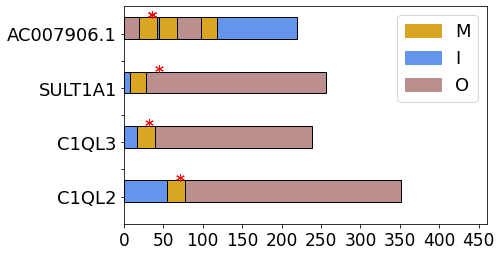

In [182]:
fig, ax = plt.subplots(1, figsize=(6.5, 4))

ax.set_ylim(0, 4)
ax.set_yticks(np.arange(0.5, 4, 0.5))

l = [[x, ''] * 1 for x in list(coordinates.keys())]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 460)
ax.set_xticks(np.arange(0, 460, 50))
ax.set_xticklabels(np.arange(0, 460, 50), fontsize=17)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0]
    coo = blocks[1]
    tr_id = tmp[tmp['gene'] == gene].iloc[0].tr_id_x
    
    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'M') | (feat_type == 'm'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif (feat_type == 'o') | (feat_type == 'O'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'rosybrown'))
        elif feat_type == 'i':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            continue
         
        cds_pos = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
        plt.text(x=cds_pos, y=y1+0.30, s='*', color='red', size=18)
        print (gene, cds_pos)

# legend 

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='M')
I = mpatches.Patch(color='cornflowerblue', label='I')
O = mpatches.Patch(color='rosybrown', label='O')

plt.legend(handles=[M, I, O])

### Combine them into 1 plot? phyloset and riboset 

In [426]:
# add coo from PhyloSET

coordinates = {}

for row in tmp.to_numpy():
    gene = row[1]
    seq = row[2]
    tr_id = row[0]
    
    cds_pos = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
    
    coordinates[gene+'_'+str(cds_pos)] = []
    
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        coordinates[gene+'_'+str(cds_pos)].append(block) 
    
        
        
# add coo from RiboSET 

for row in TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['ext_len']][['gene', 'prediction_seq']].to_numpy():
    gene = row[0]
    seq = row[1]
    
    # add cds_coo 
    cds_pos = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len
    
    coordinates[gene+'_'+str(cds_pos)] = []
    
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        
        coordinates[gene+'_'+str(cds_pos)].append(block)  
        
    
        
coordinates

{'C1QL2_65': [['i', 0, 55], ['M', 55, 78], ['O', 78, 352]],
 'C1QL3_26': [['i', 0, 16], ['M', 16, 39], ['O', 39, 239]],
 'SULT1A1_39': [['i', 0, 8], ['M', 8, 28], ['O', 28, 256]],
 'AC007906.1_30': [['o', 0, 19],
  ['M', 19, 42],
  ['i', 42, 44],
  ['M', 44, 67],
  ['o', 67, 98],
  ['M', 98, 118],
  ['i', 118, 220]],
 'PDIA6_10': [['i', 0, 8], ['M', 8, 31], ['O', 31, 450]],
 'TRMT10C_18': [['i', 0, 6], ['M', 6, 29], ['O', 29, 421]],
 'SOX2_85': [['i', 0, 16], ['M', 16, 36], ['O', 36, 402]],
 'LY6K_57': [['o', 0, 50],
  ['M', 50, 73],
  ['i', 73, 201],
  ['M', 201, 221],
  ['o', 221, 222]],
 'CD59_16': [['o', 0, 14], ['M', 14, 37], ['i', 37, 144]],
 'TIMP3_15': [['i', 0, 6], ['M', 6, 29], ['O', 29, 226]],
 'KDELR3_35': [['o', 0, 33],
  ['M', 33, 56],
  ['i', 56, 90],
  ['M', 90, 113],
  ['o', 113, 127],
  ['M', 127, 143],
  ['i', 143, 149],
  ['M', 149, 172],
  ['o', 172, 181],
  ['M', 181, 201],
  ['i', 201, 213],
  ['M', 213, 235],
  ['o', 235, 249]],
 'CD99_13': [['i', 0, 12],
  ['M'

In [427]:
blocks

('SOX2_85',
 [['CYTOPLASMIC', 1, 16], ['TRANSMEM', 17, 40], ['undefined', 41, 402]])

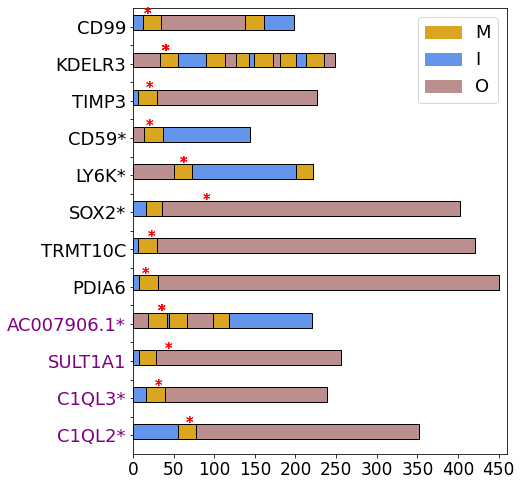

In [439]:
fig, ax = plt.subplots(1, figsize=(6.7, 8.2))

ax.set_ylim(0, 12)
ax.set_yticks(np.arange(0.5, 12, 0.5))

lab =  ['C1QL2*',
 'C1QL3*',
 'SULT1A1',
 'AC007906.1*',
 'PDIA6',
 'TRMT10C',
 'SOX2*',
 'LY6K*',
 'CD59*',
 'TIMP3',
 'KDELR3',
 'CD99']

l = [[x, ''] * 1 for x in lab]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 460)
ax.set_xticks(np.arange(0, 460, 50))
ax.set_xticklabels(np.arange(0, 460, 50), fontsize=17)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0].split('_')[0]
    cds_pos = int(blocks[0].split('_')[1])
    coo = blocks[1]

    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'M') | (feat_type == 'm'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif (feat_type == 'o') | (feat_type == 'O'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'rosybrown'))
        elif feat_type == 'i':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            continue
         
        plt.text(x=cds_pos, y=y1+0.30, s='*', color='red', size=15)


# legend 

colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']

for ytick, color in zip(ax.get_yticklabels()[0:16], colors):
    ytick.set_color(color)
    

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='M')
I = mpatches.Patch(color='cornflowerblue', label='I')
O = mpatches.Patch(color='rosybrown', label='O')

plt.legend(handles=[M, I, O])

In [429]:
# add ['CD59', 'LY6K', 'SOX2']
# add ['AC007906.1', 'C1QL3', 'C1QL2']

In [430]:
[x.split('_')[0] for x in list(coordinates.keys())]

['C1QL2',
 'C1QL3',
 'SULT1A1',
 'AC007906.1',
 'PDIA6',
 'TRMT10C',
 'SOX2',
 'LY6K',
 'CD59',
 'TIMP3',
 'KDELR3',
 'CD99']

## What's interesting about these genes? In HPA, what are they?

In [220]:
phyloset_tm = ['C1QL2','C1QL3', 'SULT1A1', 'AC007906.1']
riboset_tm = ['PDIA6','TRMT10C','SOX2', 'LY6K', 'CD59', 'TIMP3', 'KDELR3', 'CD99']

In [221]:
sel_loc[sel_loc['gene'].isin(riboset_tm)]

,gene,Main location,Additional location,Extracellular location
16,CD99,Golgi apparatus,NaN,NaN
1679,KDELR3,Endoplasmic reticulum,NaN,NaN
6115,PDIA6,Cytosol;Endoplasmic reticulum,NaN,NaN
7529,LY6K,Plasma membrane,Nucleoplasm,Predicted to be secreted
9525,TRMT10C,Mitochondria,Nucleoplasm,NaN
10205,SOX2,Nucleoplasm,NaN,NaN


According to HPA, only for LY6K the location is 'Plasma membrane' and 'Nucleoplasm', while CD99 is assigned with 'Golgi apparatus', 
KDELR3 is in 'Endoplasmic reticulum', PDIA6 can be found in 'Cytosol', 'Endoplasmic reticulum', TRMT10C has 'Mitochondria' and 'Nucleoplasm' location and SOX2 resides in 'Nucleoplasm'. 

In [ ]:
sel_

In [222]:
sel_loc[sel_loc['gene'].isin(phyloset_tm)]

,gene,Main location,Additional location,Extracellular location


In [223]:
', '.join(phyloset_tm)

'C1QL2, C1QL3, SULT1A1, AC007906.1'

In [226]:
localisation_df[localisation_df['Gene'] == 'SULT1A1']

,Gene,Gene name,Reliability,Main location,Additional location,Extracellular location,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id


In [228]:
40/60, 318/392

(0.6666666666666666, 0.8112244897959183)

In [ ]:
67% and 80% 

# Phobius 

## RiboSet

In [229]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_and_phobius_data/phobius101_linux/tmp/tmpE9zr6U/phobius/riboset.ph.out'



'/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_and_phobius_data/phobius101_linux/tmp/tmpE9zr6U/phobius/riboset.ph.out'

In [265]:
my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

In [266]:
li[1].split('\n')

['ENST00000379389.4_ISG15',
 'FT   DOMAIN        1    183       NON CYTOPLASMIC.',
 '//',
 '']

In [267]:
li[2].split('\n')

['ENST00000349431.10_UBE2J2',
 'FT   DOMAIN        1    243       NON CYTOPLASMIC.',
 'FT   TRANSMEM    244    265       ',
 'FT   DOMAIN      266    275       CYTOPLASMIC.',
 '//',
 '']

In [282]:
li1 = []


for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])

In [290]:
phob_riboset_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_riboset_parse_df[0:5]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000379389.4,ISG15,DOMAIN,1,183,None
1,ENST00000349431.10,UBE2J2,DOMAIN,1,243,None
2,ENST00000349431.10,UBE2J2,TRANSMEM,244,265,None
3,ENST00000349431.10,UBE2J2,DOMAIN,266,275,CYTOPLASMIC.
4,ENST00000338370.7,AURKAIP1,DOMAIN,1,298,None


In [304]:
print ('# genes in RIboSET with TM domain by Phobius')
print (phob_riboset_parse_df[(phob_riboset_parse_df['feat_type'] == 'TRANSMEM') & 
                            (~phob_riboset_parse_df['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ']))].gene.nunique())

# genes in RIboSET with TM domain by Phobius
88


## Ovlp with TMHMM 

In [322]:
tmhmm_ribo = list(parse_df_r[(parse_df_r['any_m'] == True) & 
         (~parse_df_r['gene'].isin(['PTPRJ', 'STIM2', 'AP3S1']))].gene.unique())

phobius_ribo = list(phob_riboset_parse_df[(phob_riboset_parse_df['feat_type'] == 'TRANSMEM') & 
                            (~phob_riboset_parse_df['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ']))].gene.unique())

print (len(tmhmm_ribo))
print (len(phobius_ribo))

print (len(set(tmhmm_ribo).intersection(phobius_ribo)))

83
88
75


### Genes where 1st TM domain is before CDS 

In [395]:
res = dict(tuple(phob_riboset_parse_df[(phob_riboset_parse_df['feat_type'] == 'TRANSMEM') & 
                            (~phob_riboset_parse_df['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ']))].groupby('gene')))

In [396]:
selected_ribo_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    # cds_coo 
    cds_coo = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len
    
    # 
    if first_tm < cds_coo:
        selected_ribo_genes.append(gene)

In [397]:
', '.join(selected_ribo_genes)

'CD59, CDC42SE2, GNS, LY6K, SOX2'

In [ ]:
phyloset_tm = ['C1QL2','C1QL3', 'SULT1A1', 'AC007906.1']
riboset_tm = ['PDIA6',
              'TRMT10C',
              'SOX2', # OK phobius 
              'LY6K', # OK  phobius
              'CD59', # OK  phobius
              'TIMP3', 
              'KDELR3', 
              'CD99']

phobius_tm_extra = ['CDC42SE2', 'GNS', 'STIM2']

## Plot in supplementaries 

In [338]:
res2 = dict(tuple(phob_riboset_parse_df.groupby('gene')))

coordinates = {}

for gene, df in res2.items():
    if gene in selected_ribo_genes:
        
        
        
        cds_pos = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len
        
        coordinates[gene+'_'+str(cds_pos)] = []
        
        #print (gene)
        #print (df)
        
        for row in df.to_numpy():
            start = row[3]
            stop = row[4]
            
            ft = row[2]
            loc = row[5]
            
            if loc == 'CYTOPLASMIC.':
                ann = 'CYTOPLASMIC'
            elif ft == 'TRANSMEM':
                ann = 'TRANSMEM'
            else:
                ann = 'undefined'
                   
            coordinates[gene+'_'+str(cds_pos)].append([ann, start, stop])

In [339]:
coordinates

{'CD59_16': [['CYTOPLASMIC', 1, 11],
  ['TRANSMEM', 12, 35],
  ['undefined', 36, 144]],
 'CDC42SE2_34': [['undefined', 1, 23],
  ['TRANSMEM', 24, 47],
  ['CYTOPLASMIC', 48, 118]],
 'GNS_51': [['CYTOPLASMIC', 1, 20],
  ['TRANSMEM', 21, 39],
  ['undefined', 40, 75],
  ['TRANSMEM', 76, 94],
  ['CYTOPLASMIC', 95, 603]],
 'LY6K_57': [['undefined', 1, 51],
  ['TRANSMEM', 52, 73],
  ['CYTOPLASMIC', 74, 200],
  ['TRANSMEM', 201, 221],
  ['undefined', 222, 222]],
 'SOX2_85': [['CYTOPLASMIC', 1, 16],
  ['TRANSMEM', 17, 40],
  ['undefined', 41, 402]]}

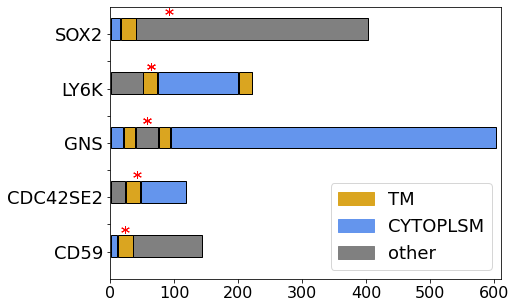

In [348]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0.5, 5, 0.5))

l = [[x, ''] * 1 for x in [x.split('_')[0] for x in list(coordinates.keys())]]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 610)
ax.set_xticks(np.arange(0, 610, 100))
ax.set_xticklabels(np.arange(0, 610, 100), fontsize=16)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0].split('_')[0]
    cds_pos = int(blocks[0].split('_')[1])
    coo = blocks[1]

    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'TRANSMEM'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif feat_type == 'CYTOPLASMIC':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'grey'))
         
        plt.text(x=cds_pos, y=y1+0.34, s='*', color='red', size=18)


# legend 

#colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']

#for ytick, color in zip(ax.get_yticklabels()[0:16], colors):
#    ytick.set_color(color)
    

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='TM')
I = mpatches.Patch(color='cornflowerblue', label='CYTOPLSM')
O = mpatches.Patch(color='grey', label='other')

plt.legend(handles=[M, I, O])

# Same for PhyloSET

In [381]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/tmhmm_and_phobius_data/phobius101_linux/tmp/tmpE9zr6U/phobius/phyloset.ph.out'

my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

li1 = []


for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])
            
phob_phyloset_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_phyloset_parse_df[0:5]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000377898.3,HES3,DOMAIN,1,207,None
1,ENST00000400907.6,RERE,DOMAIN,1,608,None
2,ENST00000455833.6,IFFO2,DOMAIN,1,635,None
3,ENST00000373824.8,TAF12,DOMAIN,1,193,None
4,ENST00000357214.5,SFPQ,DOMAIN,1,740,None


In [382]:
print ('# genes in PhyloSET with TM domain by Phobius')
print (phob_phyloset_parse_df[(phob_phyloset_parse_df['feat_type'] == 'TRANSMEM') & 
                            (~phob_phyloset_parse_df['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ']))].gene.nunique())

# genes in PhyloSET with TM domain by Phobius
13


### ovlps with TMHMM 

In [383]:
tmhmm_phylo = list(parse_df[(parse_df['any_m'] == True)].gene.unique())

phobius_phylo = list(phob_phyloset_parse_df[(phob_phyloset_parse_df['feat_type'] == 'TRANSMEM')].gene.unique())

print (len(tmhmm_phylo))
print (len(phobius_phylo))

print (len(set(tmhmm_phylo).intersection(phobius_phylo)))

12
13
11


### Check where cds_pos > 1st_TM helix start 

In [384]:
res = dict(tuple(phob_phyloset_parse_df[(phob_phyloset_parse_df['feat_type'] == 'TRANSMEM')].groupby('gene')))

selected_phylo_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    tr_id = df.iloc[0].tr_id
    
    # cds_coo 
    cds_coo = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
    
    # 
    if first_tm < cds_coo:
        selected_phylo_genes.append(gene)

In [385]:
', '.join(selected_phylo_genes)

'AC007906.1, C1QL2, C1QL3'

# Plot in  supplements 

In [386]:
res2 = dict(tuple(phob_phyloset_parse_df.groupby('gene')))

coordinates = {}

for gene, df in res2.items():
    if gene in selected_phylo_genes:
        
        tr_id = df.iloc[0].tr_id
    
        # cds_coo 
        cds_coo = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
        
        coordinates[gene+'_'+str(cds_pos)] = []
        
        #print (gene)
        #print (df)
        
        for row in df.to_numpy():
            start = row[3]
            stop = row[4]
            
            ft = row[2]
            loc = row[5]
            
            if loc == 'CYTOPLASMIC.':
                ann = 'CYTOPLASMIC'
            elif ft == 'TRANSMEM':
                ann = 'TRANSMEM'
            else:
                ann = 'undefined'
                   
            coordinates[gene+'_'+str(cds_pos)].append([ann, start, stop])

In [387]:
coordinates

{'AC007906.1_85': [['undefined', 1, 19],
  ['TRANSMEM', 20, 38],
  ['CYTOPLASMIC', 39, 44],
  ['TRANSMEM', 45, 64],
  ['undefined', 65, 111],
  ['TRANSMEM', 112, 132],
  ['CYTOPLASMIC', 133, 220]],
 'C1QL2_85': [['CYTOPLASMIC', 1, 54],
  ['TRANSMEM', 55, 78],
  ['undefined', 79, 352]],
 'C1QL3_85': [['CYTOPLASMIC', 1, 30],
  ['TRANSMEM', 31, 53],
  ['undefined', 54, 295],
  ['CYTOPLASMIC', 1, 16],
  ['TRANSMEM', 17, 39],
  ['undefined', 40, 239]]}

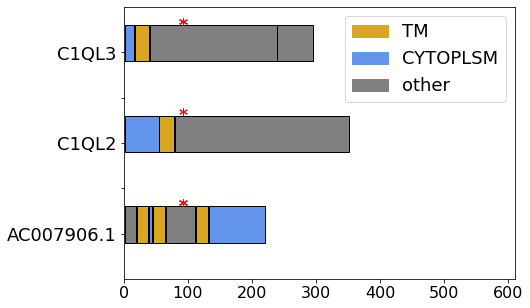

In [388]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0.5, 3, 0.5))

l = [[x, ''] * 1 for x in [x.split('_')[0] for x in list(coordinates.keys())]]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 610)
ax.set_xticks(np.arange(0, 610, 100))
ax.set_xticklabels(np.arange(0, 610, 100), fontsize=16)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0].split('_')[0]
    cds_pos = int(blocks[0].split('_')[1])
    coo = blocks[1]

    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'TRANSMEM'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif feat_type == 'CYTOPLASMIC':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'grey'))
         
        plt.text(x=cds_pos, y=y1+0.34, s='*', color='red', size=18)


# legend 

#colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']

#for ytick, color in zip(ax.get_yticklabels()[0:16], colors):
#    ytick.set_color(color)
    

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='TM')
I = mpatches.Patch(color='cornflowerblue', label='CYTOPLSM')
O = mpatches.Patch(color='grey', label='other')

plt.legend(handles=[M, I, O])

# Make one Phobius plot out of RiboSET and PhyloSET 

In [419]:
coordinates = {}



# PhyloSET genes 

res2 = dict(tuple(phob_phyloset_parse_df.groupby('gene')))

for gene, df in res2.items():
    if gene in selected_phylo_genes:
        
        tr_id = df.iloc[0].tr_id
    
        # cds_coo 
        cds_coo = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
        
        coordinates[gene+'_'+str(cds_pos)] = []
        
        #print (gene)
        #print (df)
        
        for row in df.to_numpy():
            start = row[3]
            stop = row[4]
            
            ft = row[2]
            loc = row[5]
            
            if loc == 'CYTOPLASMIC.':
                ann = 'CYTOPLASMIC'
            elif ft == 'TRANSMEM':
                ann = 'TRANSMEM'
            else:
                ann = 'undefined'
                   
            coordinates[gene+'_'+str(cds_pos)].append([ann, start, stop])

# RiboSET genes 

res2 = dict(tuple(phob_riboset_parse_df.groupby('gene')))

for gene, df in res2.items():
    if gene in selected_ribo_genes:
        
        cds_pos = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len       
        coordinates[gene+'_'+str(cds_pos)] = []

        for row in df.to_numpy():
            start = row[3]
            stop = row[4]
            
            ft = row[2]
            loc = row[5]
            
            if loc == 'CYTOPLASMIC.':
                ann = 'CYTOPLASMIC'
            elif ft == 'TRANSMEM':
                ann = 'TRANSMEM'
            else:
                ann = 'undefined'
                   
            coordinates[gene+'_'+str(cds_pos)].append([ann, start, stop])

In [420]:
len(list(coordinates.keys()))

8

In [421]:
selected_phylo_genes, selected_ribo_genes

(['AC007906.1', 'C1QL2', 'C1QL3'], ['CD59', 'CDC42SE2', 'GNS', 'LY6K', 'SOX2'])

In [422]:
coordinates

{'AC007906.1_85': [['undefined', 1, 19],
  ['TRANSMEM', 20, 38],
  ['CYTOPLASMIC', 39, 44],
  ['TRANSMEM', 45, 64],
  ['undefined', 65, 111],
  ['TRANSMEM', 112, 132],
  ['CYTOPLASMIC', 133, 220]],
 'C1QL2_85': [['CYTOPLASMIC', 1, 54],
  ['TRANSMEM', 55, 78],
  ['undefined', 79, 352]],
 'C1QL3_85': [['CYTOPLASMIC', 1, 30],
  ['TRANSMEM', 31, 53],
  ['undefined', 54, 295],
  ['CYTOPLASMIC', 1, 16],
  ['TRANSMEM', 17, 39],
  ['undefined', 40, 239]],
 'CD59_16': [['CYTOPLASMIC', 1, 11],
  ['TRANSMEM', 12, 35],
  ['undefined', 36, 144]],
 'CDC42SE2_34': [['undefined', 1, 23],
  ['TRANSMEM', 24, 47],
  ['CYTOPLASMIC', 48, 118]],
 'GNS_51': [['CYTOPLASMIC', 1, 20],
  ['TRANSMEM', 21, 39],
  ['undefined', 40, 75],
  ['TRANSMEM', 76, 94],
  ['CYTOPLASMIC', 95, 603]],
 'LY6K_57': [['undefined', 1, 51],
  ['TRANSMEM', 52, 73],
  ['CYTOPLASMIC', 74, 200],
  ['TRANSMEM', 201, 221],
  ['undefined', 222, 222]],
 'SOX2_85': [['CYTOPLASMIC', 1, 16],
  ['TRANSMEM', 17, 40],
  ['undefined', 41, 402]]}

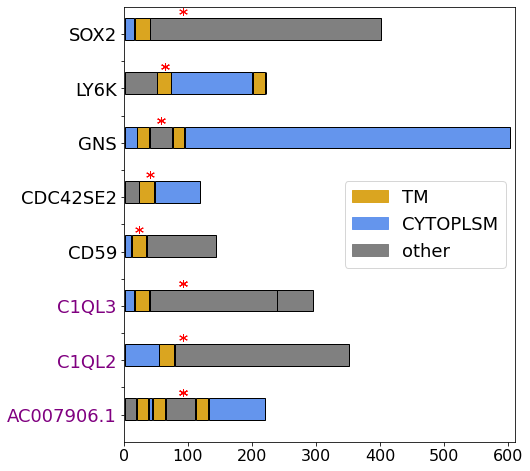

In [425]:
fig, ax = plt.subplots(1, figsize=(7,8))

ax.set_ylim(0, 8)
ax.set_yticks(np.arange(0.5, 8, 0.5))

l = [[x, ''] * 1 for x in [x.split('_')[0] for x in list(coordinates.keys())]]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 610)
ax.set_xticks(np.arange(0, 610, 100))
ax.set_xticklabels(np.arange(0, 610, 100), fontsize=16)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0].split('_')[0]
    cds_pos = int(blocks[0].split('_')[1])
    coo = blocks[1]

    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'TRANSMEM'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif feat_type == 'CYTOPLASMIC':
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'grey'))
         
        plt.text(x=cds_pos, y=y1+0.34, s='*', color='red', size=18)


# legend 

colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple']

for ytick, color in zip(ax.get_yticklabels()[0:16], colors):
    ytick.set_color(color)
    

plt.rcParams["legend.fontsize"] = 18
M = mpatches.Patch(color='goldenrod', label='TM')
I = mpatches.Patch(color='cornflowerblue', label='CYTOPLSM')
O = mpatches.Patch(color='grey', label='other')

plt.legend(handles=[M, I, O])

# HPA localisations for Phobius predictions 

In [440]:
sel_loc[sel_loc['gene'].isin(selected_phylo_genes+selected_ribo_genes)]

,gene,Main location,Additional location,Extracellular location
7529,LY6K,Plasma membrane,Nucleoplasm,Predicted to be secreted
10205,SOX2,Nucleoplasm,NaN,NaN


# Supplementary tables 

### SignalP: riboset and phyloset 

In [500]:
tmp = signalP_df_r[(signalP_df_r['class'] != 'OTHER') & 
             (signalP_df_r['SP_seq'] != 'CS pos: ?. Probable protein fragment')][['tr_id', 'gene', 
                                                                                  'class', 'SP_score', 'Other_score', 
                                                                                 'SP_seq']]


tmp['class'] = 'RiboSET'

tmp.to_csv('Supplementary_tables_and_plots/tables/S9_signalP.txt', sep='\t', index=False)

### TargetP: riboset and phyloset 

In [507]:
tmp = targetP_riboset[(targetP_riboset['seq_m'].notna()) & (targetP_riboset['class'] == 'mTP')][['gene', 'tr_id', 
                                                                                          'class', 'score_other',
                                                                                          'score_sp', 'score_m',
                                                                                          'seq_m']]

tmp.columns = ['gene', 'tr_id', 'pred_class', 'score_other', 'score_sp', 'score_m', 'seq_m']

tmp['class'] = 'RiboSET'

tmp.to_csv('Supplementary_tables_and_plots/tables/S9_targetP.txt', sep='\t', index=False)

### TMHMM_RiboSET_PhyloSET

In [450]:
tmp2 = parse_df[(parse_df['any_m'] == True)][['tr_id', 'gene', 'real_seq', 'prediction_seq']]
tmp2['class'] = 'PhyloSET'

In [451]:
tmp1 = parse_df_r[(parse_df_r['any_m'] == True) & 
         (~parse_df_r['gene'].isin(['PTPRJ', 'STIM2', 'AP3S1']))][['tr_id', 'gene', 'real_seq', 'prediction_seq']]

tmp1['class'] = 'RiboSET'

In [452]:
pd.concat([tmp1, tmp2]).to_csv('Supplementary_tables_and_plots/tables/S9_TMHMM_PhyloSET_RiboSET.txt', sep='\t', index=False)

### Phobius_RiboSET_PhyloSET

In [462]:
tmp2 = phob_phyloset_parse_df[phob_phyloset_parse_df['gene'].isin(selected_phylo_genes)]
tmp2['class'] = 'PhyloSET'

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [463]:
tmp1 = phob_riboset_parse_df[phob_riboset_parse_df['gene'].isin(selected_ribo_genes)]
tmp1['class'] = 'RiboSET'

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [465]:
pd.concat([tmp1, tmp2]).to_csv('Supplementary_tables_and_plots/tables/S9_Phobius_PhyloSET_RiboSET.txt', sep='\t', index=False)

-------------------

In [453]:
RiboSET[RiboSET['gene'].isin(['PDLIM2', 'PNC1', 'PBK', 'WDR3', 'HRG1'])]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,start_codon_local_coo_start,start_codon


In [454]:
PhyloSET[PhyloSET['gene'].isin(['PDLIM2', 'PNC1', 'PBK', 'WDR3', 'HRG1'])]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type
